<img src="http://openenergy-platform.org/static/OEP_logo_2_no_text.svg" alt="OpenEnergy Platform" height="100" width="100"  align="left"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Bhl_neue_wege_logo_transparent.svg/2000px-Bhl_neue_wege_logo_transparent.svg.png" alt="BHL" height="300" width="300" align="right"/>

# OpenEnergyPlatform
<br><br>

# MaStR - OPSD - Comparison
Repository: https://github.com/OpenEnergyPlatform/data-preprocessing/tree/master/data-import/bnetza_mastr

Please report bugs and improvements here: https://github.com/OpenEnergyPlatform/data-preprocessing/issues <br>
How to get started with Jupyter Notebooks can be found here: https://github.com/OpenEnergyPlatform/oeplatform/wiki

In [1]:
__copyright__ = "Bauhaus Luftfahrt e.V."
__license__   = "GNU Affero General Public License Version 3 (AGPL-3.0)"
__url__       = "https://github.com/openego/data_processing/blob/master/LICENSE"
__author__    = "Benjamin W. Portner"

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Data-import" data-toc-modified-id="Data-import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison</a></span><ul class="toc-item"><li><span><a href="#OEP" data-toc-modified-id="OEP-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>OEP</a></span></li><li><span><a href="#OPSD" data-toc-modified-id="OPSD-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>OPSD</a></span></li><li><span><a href="#Cleaning-and-re-comparison" data-toc-modified-id="Cleaning-and-re-comparison-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Cleaning and re-comparison</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Abstract

[Open Power System Data](https://open-power-system-data.org/) is a platform for the collection of energy data and models. It aims at "realising the efficiency and quality gains of centralised data provision by collecting, checking, processing, aggregating, documenting and publishing data required by most modellers" ([Source](https://www.sciencedirect.com/science/article/pii/S0306261918318130?via%3Dihub)). As such, it's aims are in accordance with the OEP. Recently, the OEP started offering access to data from the German Marktstammdatenregister (MaStR) containing all renewable power plants in Germany. The OPSD on the other hand, offers datasets of renewable and fossil power plants for most European countries. In this notebook, I will compare the OPSD's data on hydro, wind and biomass power plants in Germany with the OEP-MaStR dataset.

## Data import

First off, package imports:

In [ ]:
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
import upsetplot

Load and merge OEP-MaStR-data v. 1.4:

In [ ]:
version = '1.4'

fn_wind = f'bnetza_mastr_rli_v{version}_wind'
df_wind = pd.read_csv(f'data/OEP/bnetza_mastr_power-units_rli_v{version}/{fn_wind}.csv', 
                      encoding='utf8', sep=';', parse_dates=["Inbetriebnahmedatum"], dtype={"Postleitzahl":str}, low_memory=False)

fn_hydro = f'bnetza_mastr_rli_v{version}_hydro'
df_hydro = pd.read_csv(f'data/OEP/bnetza_mastr_power-units_rli_v{version}/{fn_hydro}.csv', 
                       encoding='utf8', sep=';', parse_dates=["Inbetriebnahmedatum"], dtype={"Postleitzahl":str}, low_memory=False)

fn_biomass = f'bnetza_mastr_rli_v{version}_biomass'
df_biomass = pd.read_csv(f'data/OEP/bnetza_mastr_power-units_rli_v{version}/{fn_biomass}.csv', 
                         encoding='utf8', sep=';', parse_dates=["Inbetriebnahmedatum"], dtype={"Postleitzahl":str}, low_memory=False)

df_OEP = df_wind.append(df_hydro, ignore_index=True, sort=False).append(df_biomass, ignore_index=True, sort=False)

Load OPSD renewables data:

In [4]:
# load renewables
df_renewables = pd.read_csv(
    "data/OPSD/renewable_power_plants_DE.csv",
    sep=";", encoding="latin", parse_dates=["commissioning_date"]
)

# keep only wind, bioenergy and hydro
df_renewables = df_renewables[df_renewables["energy_source_level_2"].isin(["Wind","Bioenergy","Hydro"])]

# rename columns for compatibiliy with OEP data
df_renewables.rename(columns={
    "energy_source_level_2": "Einheittyp",
    "address" : "Standort",
    "federal_state": "Bundesland",
    "commissioning_date": "Inbetriebnahmedatum",
    "electrical_capacity": "Bruttoleistung",
    "lat": "Breitengrad",
    "lon": "Laengengrad",
    "eeg_id": "AnlagenschluesselEeg",
}, inplace=True)

# add columns which are not defined in OPSD data
df_renewables["Name"] = None
df_renewables["Land"] = "Deutschland"

# rename types for compatibility with OEP
df_renewables["Einheittyp"].replace({"Hydro": "Wasser", "Bioenergy": "Biomasse", "Wind": "Windeinheit"}, inplace=True)

For reasons unknown to me, some hydro and biomass power plants are left out of the renewables dataset. Instead they are contained in the conventional data. Load OPSD conventional data, filter biomass, hydro and wind. Merge with renewables:

In [5]:
# load conventional
df_conv = pd.read_csv(
    "data/OPSD/conventional_power_plants_DE.csv",
    sep = ",", encoding = "latin", decimal=".", dtype={"commissioned": str}
)

# keep only wind, bioenergy and hydro
df_conv = df_conv[df_conv["energy_source_level_2"].isin(["Wind","Bioenergy","Hydro"])]

# commissioning dates are given as string with format YYYY.0 - Parse manually:
df_conv["commissioned"] = pd.to_datetime(df_conv["commissioned"], format="%Y.0")

# rename columns for compatibiliy with OEP data
df_conv.rename(columns={
    "energy_source_level_2": "Einheittyp",
    "street": "Standort",
    "state": "Bundesland",
    "commissioned": "Inbetriebnahmedatum",
    "capacity_gross_uba": "Bruttoleistung",
    "lat": "Breitengrad",
    "lon": "Laengengrad",
    "eeg": "AnlagenschluesselEeg",
}, inplace=True)

# add columns which are not defined in OPSD data
df_conv["Land"] = "Deutschland"
df_conv["Name"] = df_conv["name_bnetza"].fillna("") + df_conv["name_uba"].fillna("")

# rename types for compatibility with OEP
df_conv["Einheittyp"].replace({"Hydro": "Wasser", "Bioenergy": "Biomasse", "Wind": "Windeinheit"}, inplace=True)

# merge
df_OPSD = df_renewables.append(df_conv, ignore_index=True, sort=False)

## Comparison

Divide OEP and OPSD datasets into four sets each:
- plants without EEG ID
- hydro
- biomass
- wind

In [6]:
df_OEP_no_EEG = df_OEP[df_OEP["AnlagenschluesselEeg"].isna()]
df_OEP_EEG = df_OEP[~df_OEP["AnlagenschluesselEeg"].isna()]
df_OEP_biomass = df_OEP_EEG[df_OEP_EEG["Einheittyp"]=="Biomasse"]
df_OEP_hydro = df_OEP_EEG[df_OEP_EEG["Einheittyp"]=="Wasser"]
df_OEP_wind = df_OEP_EEG[df_OEP_EEG["Einheittyp"]=="Windeinheit"]

df_OPSD_no_EEG = df_OPSD[df_OPSD["AnlagenschluesselEeg"].isna()]
df_OPSD_EEG = df_OPSD[~df_OPSD["AnlagenschluesselEeg"].isna()]
df_OPSD_biomass = df_OPSD_EEG[df_OPSD_EEG["Einheittyp"]=="Biomasse"]
df_OPSD_hydro = df_OPSD_EEG[df_OPSD_EEG["Einheittyp"]=="Wasser"]
df_OPSD_wind = df_OPSD_EEG[df_OPSD_EEG["Einheittyp"]=="Windeinheit"]

Get unique EEG IDs for each set. Plot number and intersections using [UpSetPlot](https://github.com/jnothman/UpSetPlot).

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x1cf68278>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x1cf81278>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x1480d128>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x148675f8>}

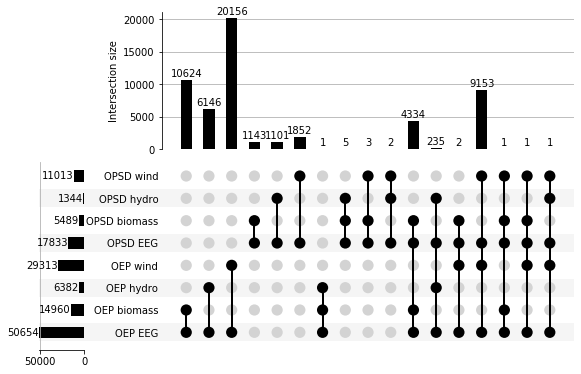

In [7]:
content = {
    "OEP EEG": df_OEP_EEG["AnlagenschluesselEeg"].unique(),
    "OEP biomass": df_OEP_biomass["AnlagenschluesselEeg"].unique(),
    "OEP hydro": df_OEP_hydro["AnlagenschluesselEeg"].unique(),
    "OEP wind": df_OEP_wind["AnlagenschluesselEeg"].unique(),
    "OPSD EEG": df_OPSD_EEG["AnlagenschluesselEeg"].unique(),
    "OPSD biomass": df_OPSD_biomass["AnlagenschluesselEeg"].unique(),
    "OPSD hydro": df_OPSD_hydro["AnlagenschluesselEeg"].unique(),
    "OPSD wind": df_OPSD_wind["AnlagenschluesselEeg"].unique(),
}
df_upset = upsetplot.from_contents(content)
upsetplot.plot(df_upset, subset_size="count", sort_categories_by=None, show_counts=True)

### OEP

The OEP-MaStR data contains 50,654 unique EEG IDs. Of these, 14,960 belong to bioenergy plants. 6,382 belong to hydro power plants. 29,313 belong to wind turbines. One EEG ID (E21875011000000000000295597000000) is incorrectly assigned both to a bioenergy plant and to a hydro power plant. This EEG ID is not contained in OPSD data so the assignment cannot be corrected:

In [8]:
df2 = df_upset.reset_index()
# OEP IDs shared between biomass and hydro
df2[(df2["OEP EEG"])&(df2["OEP biomass"])&(df2["OEP hydro"])&~(df2["OEP wind"])]

,OEP EEG,OEP biomass,OEP hydro,OEP wind,OPSD EEG,OPSD biomass,OPSD hydro,OPSD wind,id
31232,True,True,True,False,False,False,False,False,E21875011000000000000295597000000


Two EEG IDs are identified as wind turbines by the OEP-MaStR dataset but are indicated as biomass power plants in OPSD data.

In [9]:
df2[(df2["OEP wind"])&(df2["OPSD biomass"])&~(df2["OPSD wind"])]

,OEP EEG,OEP biomass,OEP hydro,OEP wind,OPSD EEG,OPSD biomass,OPSD hydro,OPSD wind,id
237,True,False,False,True,True,True,False,False,E2069801101E073718123064812309001
238,True,False,False,True,True,True,False,False,E3123801V000000000000047525090952


### OPSD

The OPSD dataset contains 17,833 unique EEG IDs. 5,489 belong to bioenergy plants, 1,344 belong to hydro power plants, 11,013 belong to wind turbines. Similar to the OEP dataset, some EEG IDs are assigned to multiple power plants of different type. 5 EEG IDs are shared between biomass and hydro plants, three of which are obviously incorrect:

In [10]:
# OPSD IDs shared between biomass and hydro
df2[(df2["OPSD EEG"])&(df2["OPSD biomass"])&(df2["OPSD hydro"])&~(df2["OPSD wind"])]

,OEP EEG,OEP biomass,OEP hydro,OEP wind,OPSD EEG,OPSD biomass,OPSD hydro,OPSD wind,id
50819,False,False,False,False,True,True,True,False,E2104101S160000000000031538200001
52493,False,False,False,False,True,True,True,False,E1084301E100000000000002608000001
54331,False,False,False,False,True,True,True,False,EEG-Anlagenschlüssel
54758,False,False,False,False,True,True,True,False,yes
54759,False,False,False,False,True,True,True,False,no


5 OPSD EEG IDs are shared between biomass and wind plants. One of these is incorrect (KWK-Anlage). Two of them occur in the OEG-MaStR data as wind (E2069801101E073718123064812309002) and biomass (E20689011000000000095221145200001) respectively. The last two do not occur in the OEP-MaStR data.

In [11]:
# OPSD IDs shared between biomass and wind
df2[(df2["OPSD EEG"])&(df2["OPSD biomass"])&~(df2["OPSD hydro"])&(df2["OPSD wind"])]

,OEP EEG,OEP biomass,OEP hydro,OEP wind,OPSD EEG,OPSD biomass,OPSD hydro,OPSD wind,id
2756,True,False,False,True,True,True,False,True,E2069801101E073718123064812309002
36003,True,True,False,False,True,True,False,True,E20689011000000000095221145200001
51085,False,False,False,False,True,True,False,True,KWK-Anlage
53835,False,False,False,False,True,True,False,True,E21897010000000000000000000100001
54342,False,False,False,False,True,True,False,True,E20793010000000000000000000010004


3 OPSD EEG-IDs are shared between hydro and wind. Two of these are incorrect. The last one is identified as a wind turbine in OEP data.

In [12]:
# OPSD IDs shared between hydro and wind
df2[(df2["OPSD EEG"])&~(df2["OPSD biomass"])&(df2["OPSD hydro"])&(df2["OPSD wind"])]

,OEP EEG,OEP biomass,OEP hydro,OEP wind,OPSD EEG,OPSD biomass,OPSD hydro,OPSD wind,id
6290,True,False,False,True,True,False,True,True,E13005011000000000001002269200001
54394,False,False,False,False,True,False,True,True,noch nicht bekannt
54438,False,False,False,False,True,False,True,True,Information liegt noch nicht vor.


### Cleaning and re-comparison

Fix wrongly assigned EEG IDs where indication is given by other dataset. Remove those where no indication is given.

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0xdeb45c0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x88832b0>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0xf262b70>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0xf262160>}

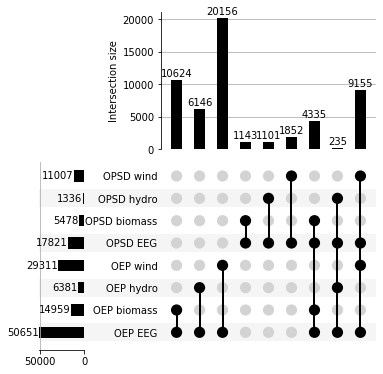

In [13]:
df2.loc[2756,"OPSD biomass"] = False
df2.loc[36003,"OPSD wind"] = False
df2.loc[6290,"OPSD hydro"] = False
df2.drop(
    [31232, 237, 238, 50819, 52493, 54331, 54758, 54759, 51085, 53835, 54342, 54394, 54438], 
    inplace=True
)
df_upset_corrected = df2.set_index(
    ["OEP EEG", "OEP biomass", "OEP hydro", "OEP wind", "OPSD EEG", "OPSD biomass", "OPSD hydro", "OPSD wind"]
)
upsetplot.plot(df_upset_corrected, subset_size="count", sort_categories_by=None, show_counts=True)

The fixed OEP dataset contains 50,651 unique EEG IDs. 14,959 of these belong to bioenergy plants. 6,381 belong to hydro power plants. 29,311 belong to wind turbines. The fixed OPSD dataset contains 17,821 unique EEG IDs. 5,478 belong to bioenergy plants, 1,336 to hydro power plants, 11,007 to wind turbines. Of the EEG IDs uniquely associated with bioenergy plants, 10,624 are contained exclusively in the OEP-MaStR data, 1,143 are contained exclusively in OPSD data and **4,335 bioenergy EEG IDs** are contained in both datasets. Of the EEG IDs uniquely associated with hydro power plants, 6,146 are contained exclusively in the OEP-MaStR data, 1,101 are contained exclusively in OPSD data and **only 235 hydro power EEG IDs** are contained in both datasets. Of the EEG IDs uniquely associated with wind power, 20,156 are contained exclusively in the OEP-MaStR data, 1,852 are contained exclusively in OPSD data and **9,155 wind power EEG IDs** are contained in both datasets.

| Type | OEP only | intersection | OPSD only | sum |
| ---------------: | -------: | ------------: | --------: | --: |
| bioenergy | 10,624 | 4,335 | 1,143 | 16,102 |
| hydro | 6,146 | 235 | 1,101 | 7,482 |
| wind | 20,156 | 9,155 | 1,852 | 31,163 |
| sum | 36,926 | 13,725 | 4,096 | 54,747 |

## Conclusion

The OEP dataset contains much more entries than the OPSD dataset. Yet, there is potential for combining them. 4,096 entries are contained in OPSD data but not in OEP-MaStR data. It should be considered whether these can be merged into OEP.